In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pandas.util.testing as tm
import statistics 
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

C:\Users\ioann\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline

### Loading .csv files into pandas dataFrame

In [4]:
us = pd.read_csv('C:\\Users\\ioann\\Desktop\\pf-ds-coh-team2\\data\\users.csv') # Users
dev = pd.read_csv('C:\\Users\\ioann\\Desktop\\pf-ds-coh-team2\\data\\devices.csv') # devices

### Merge the two datasets "users" as us and "devices" as dev into the new one called "ud"

In [5]:
ud=pd.merge(us,dev,on='user_id')

In [6]:
ud['age'] = 2020 - (ud[['birth_year']])

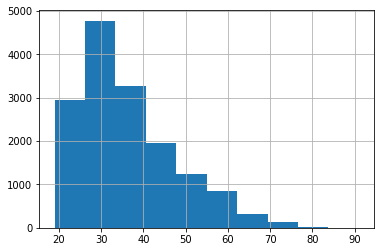

In [7]:
ud.age.hist()

In [8]:
# Replace 'SILVER' and 'GOLD' with 'PAID' in order to have two categories of plan: 'STANDARD' and 'PAID'
ud['plan'] = ud['plan'].str.replace('SILVER', 'PAID')
ud['plan'] = ud['plan'].str.replace('GOLD', 'PAID')
print("Number of customers by plan ","\n" ,ud['plan'].value_counts())

Number of customers by plan  
 STANDARD    14394
PAID         1150
Name: plan, dtype: int64


In [9]:
# Now make a dummie about plan, STANDARD=0 and PAID=1
plan_dict = {'STANDARD': 0, 'PAID': 1}
ud['plan'] = ud['plan'].map(plan_dict)
ud['plan'].value_counts()

0    14394
1     1150
Name: plan, dtype: int64

In [10]:
pd.crosstab(index=ud['brand'], columns=ud['plan'])

plan,0,1
brand,,
Android,7346,454
Apple,7025,687
Unknown,23,9


In [11]:
#Only 32 obs of unknown, so we have to replace it somehow
# Replace 'Unknown' with 'Android' in order to have two big categories of brand: 'Android' and 'Apple'
ud['brand'] = ud['brand'].str.replace('Unknown', 'Android')
ud['brand'].value_counts()

Android    7832
Apple      7712
Name: brand, dtype: int64

In [12]:
# Now make a dummie about devices, Android=0 and Apple=1
brand_dict = {'Android': 0, 'Apple': 1}
ud['brand'] = ud['brand'].map(brand_dict)
ud['brand'].value_counts()

0    7832
1    7712
Name: brand, dtype: int64

In [13]:
pd.crosstab(index=ud['attributes_notifications_marketing_email'], columns=ud['plan'])

plan,0,1
attributes_notifications_marketing_email,,
0.0,1002,73
1.0,8452,757


In [14]:
ud['attributes_notifications_marketing_push'].fillna(random.randint(0, 1),inplace=True)
#ud['attributes_notifications_marketing_push']
ud['attributes_notifications_marketing_email'].fillna(random.randint(0, 1),inplace=True)
print("Number of attributes_notifications_marketing_push ","\n" ,ud['attributes_notifications_marketing_push'].value_counts())
print("Number of attributes_notifications_marketing_email ","\n" ,ud['attributes_notifications_marketing_email'].value_counts())

Number of attributes_notifications_marketing_push  
 1.0    9752
0.0    5792
Name: attributes_notifications_marketing_push, dtype: int64
Number of attributes_notifications_marketing_email  
 1.0    9209
0.0    6335
Name: attributes_notifications_marketing_email, dtype: int64


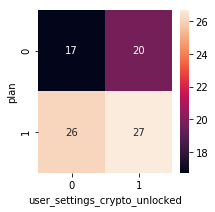

In [15]:
plt.figure(figsize=(3,3))
sns.heatmap(ud.groupby(['plan', 'user_settings_crypto_unlocked']).num_contacts.mean().unstack(),annot=True, fmt=".0f")

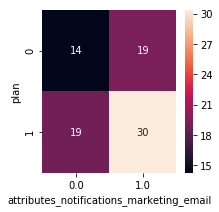

In [16]:
plt.figure(figsize=(3,3))
sns.heatmap(ud.groupby(['plan', 'attributes_notifications_marketing_email']).num_contacts.mean().unstack(),annot=True, fmt=".0f")

In [17]:
import datetime as dt
ud['created_date'] = ud['created_date'].apply(pd.to_datetime)
ud['created_year']=pd.DatetimeIndex(ud['created_date']).year
ud['created_month']=pd.DatetimeIndex(ud['created_date']).month
print("Number of customers by created year ","\n" ,ud['created_year'].value_counts())
print("Number of customers by created month ","\n" ,ud['created_month'].value_counts())

Number of customers by created year  
 2018    15494
2019       50
Name: created_year, dtype: int64
Number of customers by created month  
 12    1922
11    1555
10    1454
8     1421
3     1418
9     1407
5     1266
6     1262
7     1237
4      957
1      937
2      708
Name: created_month, dtype: int64


In [18]:
ud_new=pd.concat([pd.get_dummies(ud['created_year']), ud], axis=1)

In [19]:
ud_new.drop('created_year', axis=1, inplace=True)
ud_new.drop('num_referrals', axis=1, inplace=True)
ud_new.drop('num_successful_referrals', axis=1, inplace=True)
ud_new.drop('birth_year', axis=1, inplace=True)
ud_new.drop('created_date', axis=1, inplace=True)
ud_new.drop('user_id', axis=1, inplace=True)
ud_new.drop('country', axis=1, inplace=True)
ud_new.drop('city', axis=1, inplace=True)
ud_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15544 entries, 0 to 15543
Data columns (total 10 columns):
2018                                        15544 non-null uint8
2019                                        15544 non-null uint8
user_settings_crypto_unlocked               15544 non-null int64
plan                                        15544 non-null int64
attributes_notifications_marketing_push     15544 non-null float64
attributes_notifications_marketing_email    15544 non-null float64
num_contacts                                15544 non-null int64
brand                                       15544 non-null int64
age                                         15544 non-null int64
created_month                               15544 non-null int64
dtypes: float64(2), int64(6), uint8(2)
memory usage: 1.1 MB


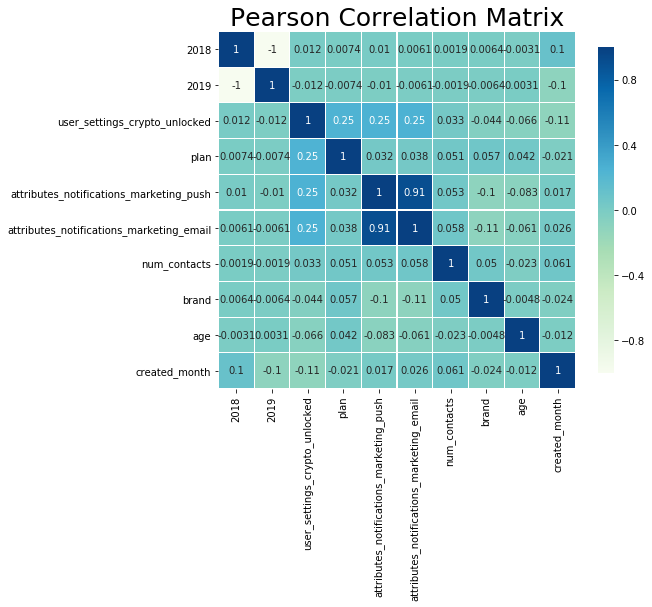

In [20]:
mask = np.zeros_like(ud_new.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = False 
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(ud_new.corr(),linewidths=0.25,vmax=1.0,square=True,cmap="GnBu", linecolor='w',annot=True,mask=mask,cbar_kws={"shrink": .75});

In [21]:
import copy
data=copy.deepcopy(ud_new)

In [22]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['plan']).values
X_columns = data.drop(columns=['plan']).columns
y = data['plan'].values
print(X.shape)
print(X_columns)
print(y.shape)
print(type(y))

(15544, 9)
Index([                                      2018,
                                             2019,
                  'user_settings_crypto_unlocked',
        'attributes_notifications_marketing_push',
       'attributes_notifications_marketing_email',
                                   'num_contacts',
                                          'brand',
                                            'age',
                                  'created_month'],
      dtype='object')
(15544,)
<class 'numpy.ndarray'>


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("X train: ", X_train.shape, "\n",
      "y train: ", y_train.shape, "\n",
      "X test: ", X_test.shape, "\n",
      "y test: ", y_test.shape, "\n")

X train:  (12435, 9) 
 y train:  (12435,) 
 X test:  (3109, 9) 
 y test:  (3109,) 



### Random Forests

In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

var = VarianceThreshold()

In [25]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_
feat_names = X_columns

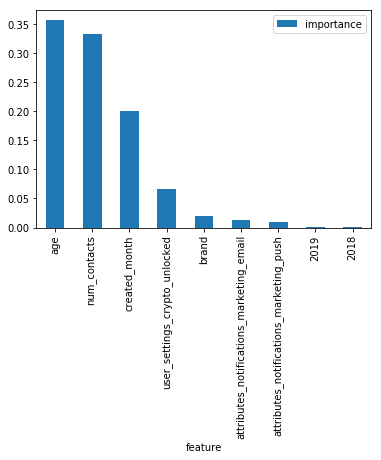

In [26]:
rf_result = pd.DataFrame({'feature': feat_names, 'importance': rf.feature_importances_})
rf_result.sort_values(by='importance',ascending=False)[:9].plot(x='feature', y='importance', kind='bar')

In [27]:
for c, imp in sorted(zip(X_columns, rf.feature_importances_), key=lambda pair: pair[1], reverse=True):
  print('{:20}: {}'.format(c, imp))

age                 : 0.3562618503589657
num_contacts        : 0.33345621719976315
created_month       : 0.20060882004571934
user_settings_crypto_unlocked: 0.06613113719775425
brand               : 0.020035037978960585
attributes_notifications_marketing_email: 0.012245985471114846
attributes_notifications_marketing_push: 0.010215891831705655
                2019: 0.0005399635769395038
                2018: 0.00050509633907711


In [28]:
from scipy import stats
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [29]:
rf_y_predict = rf.predict(X_test)
rf_mse1 = np.sqrt(metrics.mean_squared_error(y_test, rf_y_predict))
print("Random Forest MSE:", rf_mse1)
rf_rmse = rf_mse1**(1/2)
print("Random Forest RMSE:", rf_rmse)

Random Forest MSE: 0.2891853666119083
Random Forest RMSE: 0.5377595806788646


In [30]:
def plot_coefficients(classifier, feature_names, top_features=3):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(10, 7))
 colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
 plt.show()

In [31]:
# #SVR
# svm=SVR(kernel="linear",degree=1)
# svm.fit(X_train,y_train)
# svm_pred= svm.predict(X_test)
# print(svm.score(X_test,y_test))
# print(r2_score(y_test,svm_pred))

In [32]:
#Get Support Vector Regression mean squared error on test dataset
# svm_mse1 = np.sqrt(metrics.mean_squared_error(y_test, svm_pred))
# print("Support Vector Regression MSE:", svm_mse1)
# svm_rmse = svm_mse1**(1/2)
# print("Support Vector Regression RMSE:", svm_rmse)

#Get the visualisation of the most important features
# print (X_columns)
# plot_coefficients(svm, X_columns)

In [33]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

var = VarianceThreshold()

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

sampler = SMOTE()

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

pipe1 = Pipeline([('scaler', sc),
                  ('selector', var),
                  ('sampler', sampler),
                  ('model', rf)])

grid1 = {'selector__threshold': [0, 0.2, 0.4],
         'model__n_estimators': [20, 50, 100]}

clf = GridSearchCV(pipe1, grid1)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', VarianceThreshold(threshold=0.0)), ('sampler', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('model', Ra...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'selector__threshold': [0, 0.2, 0.4], 'model__n_estimators': [20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
from sklearn.metrics import classification_report
print(clf.best_params_, '\n')

print(classification_report(y_test, clf.predict(X_test)))

{'model__n_estimators': 100, 'selector__threshold': 0} 

             precision    recall  f1-score   support

          0       0.94      0.93      0.94      2879
          1       0.23      0.27      0.25       230

avg / total       0.89      0.88      0.88      3109

